In [6]:
%matplotlib widget

In [7]:

import pandas as pd

import matplotlib.pyplot as plt
import pandas_ta as ta

## Create TA strategy

In [8]:
DailyTradeStrategy = ta.Strategy(
    name="MACD, RSI, MFI",
    description="MACD 12 26 9, RSI 14, MFI 14 for daily fast trading",
    ta=[
        {"kind": "macd"},
        {"kind": "rsi"},
        {"kind": "mfi"},
    ]
)

## Load parquet

In [9]:
df = pd.read_parquet("data.parquet")

In [10]:
df.head()

,name,id,figi,ts,open_price,close_price,high_price,low_price,volume
0,JPMorgan,1,BBG000DMBXR2,2018-01-23 21:45:00+00:00,114.02,114.02,114.02,114.02,6.0
1,JPMorgan,1,BBG000DMBXR2,2018-01-23 21:35:00+00:00,114.02,114.02,114.02,114.02,10.0
2,JPMorgan,1,BBG000DMBXR2,2018-01-23 20:55:00+00:00,114.20,114.23,114.26,114.16,76837.0
3,JPMorgan,1,BBG000DMBXR2,2018-01-23 20:50:00+00:00,114.37,114.21,114.39,114.19,34299.0
4,JPMorgan,1,BBG000DMBXR2,2018-01-23 20:45:00+00:00,114.33,114.36,114.41,114.31,27240.0


In [11]:
df.groupby("name").count()

,id,figi,ts,open_price,close_price,high_price,low_price,volume
name,,,,,,,,
AT&T,101134,101134,101134,101134,101134,101134,101134,101134
Apple,119367,119367,119367,119367,119367,119367,119367,119367
JPMorgan,85536,85536,85536,85536,85536,85536,85536,85536


## Apply strategy

In [12]:
df.ta.strategy(DailyTradeStrategy)

## Add metrics

Add RSI oversold and overbought

In [18]:
RSI_oversold_threshold = 30
RSI_overbouht_threshold = 70

df["RSI_oversold"] = df["RSI_14"] <= RSI_oversold_threshold
df["RSI_overbought"] = df["RSI_14"] >= RSI_overbouht_threshold

Add MFI oversold

In [19]:
MFI_oversold_threshold = 20
MFI_overbouht_threshold = 80

df["MFI_oversold"] = df["MFI_14"] <= MFI_oversold_threshold
df["MFI_overbought"] = df["MFI_14"] >= MFI_overbouht_threshold

Add MACD signal crossover and cross under

In [17]:
df["MACD_diff"] = (df["MACD_12_26_9"] - df["MACDs_12_26_9"])
df["MACD_crossover"] = (df["MACD_diff"] >= 0) & (df["MACD_diff"].shift() <= 0)
df["MACD_crossunder"] = (df["MACD_diff"] <= 0) & (df["MACD_diff"].shift() >= 0)

## Show result

In [20]:
df.head()

,name,id,figi,ts,open_price,close_price,high_price,low_price,volume,MACD_12_26_9,...,MACDs_12_26_9,RSI_14,MFI_14,MACD_diff,MACD_crossover,MACD_crossunder,RSI_oversold,RSI_overbought,MFI_oversold,MFI_overbought
0,JPMorgan,1,BBG000DMBXR2,2018-01-23 21:45:00+00:00,114.02,114.02,114.02,114.02,6.0,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False
1,JPMorgan,1,BBG000DMBXR2,2018-01-23 21:35:00+00:00,114.02,114.02,114.02,114.02,10.0,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False
2,JPMorgan,1,BBG000DMBXR2,2018-01-23 20:55:00+00:00,114.20,114.23,114.26,114.16,76837.0,NaN,...,NaN,100.000000,NaN,NaN,False,False,False,True,False,False
3,JPMorgan,1,BBG000DMBXR2,2018-01-23 20:50:00+00:00,114.37,114.21,114.39,114.19,34299.0,NaN,...,NaN,90.697674,NaN,NaN,False,False,False,True,False,False
4,JPMorgan,1,BBG000DMBXR2,2018-01-23 20:45:00+00:00,114.33,114.36,114.41,114.31,27240.0,NaN,...,NaN,94.688458,NaN,NaN,False,False,False,True,False,False


## Limit instruments count

In [184]:
df = df[df["id"] <= 10]

In [185]:
instruments_count = df["id"].unique().size

## Preprocess data

In [186]:
metric_names = ['open_price','close_price','high_price','low_price','volume']

df_data_set = pd.DataFrame()

for metric_name in metric_names:
    # Pivot table and create data set part with single metric
    df_buf = df.pivot(index='ts', columns='id')[metric_name]
    
    # Rename column
    df_buf.columns = ['%s_%d' % (metric_name, x) for x in df_buf.columns]
    
    # Concat dataset
    df_data_set = pd.concat([df_data_set, df_buf], axis=1, sort=False)

# Add timestamp features
df_data_set['year'] = df_data_set.index.year
df_data_set['month'] = df_data_set.index.month
df_data_set['day'] = df_data_set.index.day
df_data_set['weekday'] = df_data_set.index.weekday
df_data_set['hour'] = df_data_set.index.hour
df_data_set['minute'] = df_data_set.index.minute

# Add target column
target_name = 'close_price'
# Pivot table and create data set part with single metric
df_buf = df.pivot(index='ts', columns='id')[target_name]
# Add target metric
df_buf = df_buf.shift(-1)
# Rename column
df_buf.columns = ['target_%d' % x for x in df_buf.columns]
# Concat dataset
df_data_set = pd.concat([df_data_set, df_buf], axis=1, sort=False)

# Fill NAN
df_data_set = df_data_set.fillna(method='ffill')

# Remove nan
df_data_set = df_data_set.dropna()

# Create non time columns list
data_columns_list = [x for x in df_data_set.columns if re.match('.*_\d+', x) is not None]

# # Calc percentage
# # df_data_set[data_columns_list] /= df_data_set[data_columns_list].iloc[0]
# # Calc derivative for each column
# df_data_set[data_columns_list] = df_data_set[data_columns_list].diff()
# # # Fill first row with zeros
# df_data_set = df_data_set.fillna(0)

# # Normalize data
# column_normalizer = {'year':3000, 'month':12, 'day':31, 'weekday':7, 'hour':24, 'minute':60}
# for column_name, normalizer_val in column_normalizer.items():
#     df_data_set[column_name] /= normalizer_val

# # Calc percentage
# # df_data_set /= df_data_set.iloc[0]
# # Calc derivative for each column
# df_data_set = df_data_set.diff()
# # Fill first row with zeros
# df_data_set = df_data_set.fillna(0)

print(df_data_set.shape)
df_data_set.describe()

(1298, 66)


,open_price_1,open_price_2,open_price_3,open_price_4,open_price_5,open_price_6,open_price_7,open_price_8,open_price_9,open_price_10,...,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,target_10
count,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,...,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000
mean,120.127188,210.393914,30.149006,58.696649,37.351772,49.931325,69.983698,59.416387,57.753929,1775.860154,...,120.158428,210.407473,30.155616,58.716949,37.353960,49.939168,70.002966,59.420724,57.749584,1775.580508
std,8.540918,7.195184,2.324084,5.363102,1.351878,3.098412,4.282393,1.320888,1.505259,34.398669,...,8.545964,7.199936,2.327080,5.369492,1.348308,3.094889,4.282036,1.321591,1.507506,34.406810
min,104.270000,195.730000,26.200000,49.997500,33.950000,43.380000,60.590000,55.600000,54.640000,1662.000000,...,104.260000,195.370000,26.150000,49.995000,33.900000,43.380000,60.330000,55.580000,54.670000,1652.950000
25%,112.980000,205.317500,27.980000,54.363125,36.980000,48.252500,66.902500,59.112500,56.490000,1749.212500,...,113.042500,205.315000,27.992500,54.380625,36.980000,48.260000,66.930000,59.112500,56.490000,1749.815000
50%,119.200000,209.550000,29.880000,57.392500,37.555000,49.455000,69.875000,59.810000,57.850000,1774.175000,...,119.245000,209.570000,29.885000,57.456250,37.555000,49.515000,69.880000,59.810000,57.840000,1774.080000
75%,129.040000,218.060000,32.720000,64.596875,38.227500,53.200000,74.065000,60.290000,58.795000,1802.712500,...,129.037500,218.000000,32.727500,64.614375,38.200000,53.200000,74.050000,60.290000,58.860000,1802.322500
max,135.670000,223.500000,33.780000,67.697500,39.800000,54.720000,76.240000,61.430000,61.000000,1850.700000,...,135.670000,224.090000,33.780000,67.700000,39.630000,54.750000,76.240000,61.300000,61.000000,1848.830000


<AxesSubplot:xlabel='ts'>

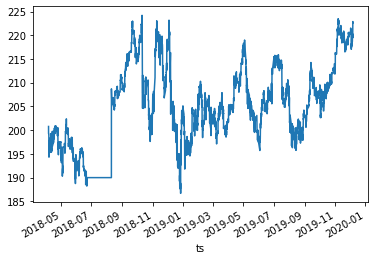

In [161]:
df_data_set.iloc[:,1].plot()

In [200]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

corrMatrix = df_data_set.corr()
target_1_corr = corrMatrix['target_1'].abs().sort_values(ascending=False)
target_1_corr = target_1_corr[target_1_corr > 0.5]
target_1_corr

target_1         1.000000
close_price_1    0.999022
high_price_1     0.998690
low_price_1      0.998652
open_price_1     0.998341
target_3         0.994202
close_price_3    0.993519
high_price_3     0.993314
low_price_3      0.993134
open_price_3     0.992622
target_7         0.982887
close_price_7    0.982096
low_price_7      0.982084
open_price_7     0.981624
high_price_7     0.981396
target_6         0.977109
close_price_6    0.976319
low_price_6      0.975972
open_price_6     0.975691
high_price_6     0.975577
target_2         0.968274
low_price_2      0.968017
open_price_2     0.967807
close_price_2    0.967730
high_price_2     0.967377
target_4         0.955991
low_price_4      0.955988
close_price_4    0.955831
open_price_4     0.955416
high_price_4     0.955292
month            0.898300
open_price_5     0.805578
close_price_5    0.804335
high_price_5     0.804116
target_5         0.803851
low_price_5      0.803247
high_price_9     0.748059
open_price_9     0.747894
target_9    

# Neural network

In [162]:
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.python.client import device_lib
from tensorflow.python.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler

import numpy as np

import matplotlib.pyplot as plt

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6110240898202823576
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13376529407255795504
physical_device_desc: "device: XLA_CPU device"
]


In [163]:
y_size = instruments_count
X_size = df_data_set.shape[1] - y_size


# Cut features and targets
X = df_data_set.iloc[:,:X_size]
y = df_data_set.iloc[:,X_size:X_size+y_size]

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)

# scale inputs with MinMaxScaler()
input_scaler =  MinMaxScaler()
# fit scaler
input_scaler.fit(X)
# transform training dataset
X_train = input_scaler.transform(X_train)
# transform test dataset
X_test = input_scaler.transform(X_test)

# Transform output with MinMaxScaler()
output_scaler = MinMaxScaler()
# fit scaler on training dataset
output_scaler.fit(y)
# transform training dataset
y_train = output_scaler.transform(y_train)
# transform test dataset
y_test = output_scaler.transform(y_test)

# Reshape and create loopback
look_back = 14 * 5

def reshape_with_look_back(look_back, dataset):
    output = np.ndarray(((dataset.shape[0] - look_back), look_back + 1, dataset.shape[1]))

    for i in range(look_back, dataset.shape[0]):
        output[i-look_back] = dataset[i-look_back:i+1]

    return output

# Create look back for input
X_train = reshape_with_look_back(look_back, X_train)
X_test = reshape_with_look_back(look_back, X_test)

# Adopt look back for output
y_train = y_train[look_back:]
y_test = y_test[look_back:]

# TODO Add forward days
# foward_days = 50

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3839, 71, 10)
(3839, 2)
(1856, 71, 10)
(1856, 2)


In [164]:
#Build the model
layer_size = 10

model = keras.Sequential()
model.add(layers.LSTM(units=layer_size,return_sequences=True,input_shape=(look_back + 1,X_size)))
model.add(layers.Dropout(0.2))
# model.add(layers.LSTM(units=layer_size,return_sequences=True))
# model.add(layers.Dropout(0.2))
# model.add(layers.LSTM(units=layer_size,return_sequences=True))
# model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=layer_size))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=y_size))
model.compile(loss=losses.Huber(), optimizer='adam', metrics=['mae'])

print(model.summary())

# Create early stop
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)
# fit model
history = model.fit(X_train,
                    y_train,
                    epochs=1000,
                    validation_data=(X_test,y_test),
                    shuffle=True,
                    batch_size=100,
                    verbose=2,
                    callbacks=[es])

# summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean absolute error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_42 (LSTM)               (None, 71, 10)            840       
_________________________________________________________________
dropout_42 (Dropout)         (None, 71, 10)            0         
_________________________________________________________________
lstm_43 (LSTM)               (None, 10)                840       
_________________________________________________________________
dropout_43 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 22        
Total params: 1,702
Trainable params: 1,702
Non-trainable params: 0
_________________________________________________________________
None
Train on 3839 samples, validate on 1856 samples
Epoch 1/1000
3839/3839 - 7s - loss: 0.0894 - mean_absolute_error

KeyboardInterrupt: 

# Prediction

In [ ]:
pred_elements_count = 2000

# transform training dataset
X_scaled = input_scaler.transform(X[len(X)-pred_elements_count:])
X_scaled = reshape_with_look_back(look_back, X_scaled)

# transform training dataset
y_scaled = output_scaler.transform(y[len(y)-pred_elements_count:])

# Adopt look back for output
y_scaled = y_scaled[look_back:]

y_pred = model.predict(X_scaled)

plt.plot(output_scaler.inverse_transform(y_pred)[:,0])
plt.plot(output_scaler.inverse_transform(y_scaled)[:,0])
# plt.plot(y_pred_test[:,0])
# plt.plot(y_train.iloc[:,0].values)

# Simulate bot

In [46]:
X_scaled.shape

(430, 71, 11)

In [31]:
points_count = y_scaled.shape[0]
real_currency = y_scaled.reshape(y_scaled.shape[0])
prediction = y_pred.reshape(y_pred.shape[0])

init_budget = 500
current_stock_count = 0

for x in range(1,points_count):
    # If currency predict raise, buy, or sell
    percent_threshold = 0.005
    if (prediction[x] - real_currency[x-1]) / real_currency[x-1] > percent_threshold:
        print('buy')
        
        
    else:
        print('sell if have')

buy
buy
buy
buy
sell if have
sell if have
sell if have
buy
sell if have
sell if have
sell if have
sell if have
buy
sell if have
sell if have
buy
buy
sell if have
buy
buy
buy
sell if have
sell if have
buy
buy
buy
buy
sell if have
sell if have
sell if have
sell if have
buy
buy
sell if have
buy
sell if have
buy
sell if have
sell if have
sell if have
buy
buy
sell if have
sell if have
sell if have
sell if have
buy
sell if have
sell if have
buy
sell if have
buy
sell if have
buy
sell if have
buy
buy
buy
sell if have
buy
buy
buy
buy
buy
buy
buy
buy
buy
buy
sell if have
buy
buy
buy
buy
buy
sell if have
buy
buy
sell if have
buy
buy
buy
buy
sell if have
buy
buy
buy
buy
buy
buy
buy
buy
buy
buy
buy
buy
sell if have
sell if have
buy
buy
buy
buy
buy
sell if have
sell if have
buy
sell if have
buy
buy
buy
buy
buy
buy
buy
buy
buy
buy
sell if have
buy
buy
buy
buy
sell if have
buy
buy
buy
sell if have
buy
buy
sell if have
buy
buy
buy
buy
buy
buy
buy
sell if have
buy
buy
buy
buy
sell if have
sell if have
b